# ParkEase:

**Name:** Arin Deloatch, Ksenia Kold, Paul Thai
**Date:** January 30, 2024  
**Class:** AAI-530 Data Analytics and Internet of Things  
**Professor:** Professor Roozbeh Sadeghian

In [65]:
# Import Libraries
import keras
import pandas as pd
import plotly.express as px
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Bidirectional, Activation, SimpleRNN, GlobalAveragePooling1D, TimeDistributed
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [66]:
# Read in the file
df = pd.read_csv("http://iot.ee.surrey.ac.uk:8080/datasets/parking/aarhus_parking.csv")

# Saving a copy (just in case) + checking if file already exists
csv_file = "aarhus_parking.csv"

# Grab current working directory
work_dir = os.getcwd()

# Perform a check
if csv_file in os.listdir(work_dir):
  print(f"{csv_file} already exists... continuing")
else:
  df.to_csv(csv_file)
  print(f"Finished downloading {csv_file}, moving on")

aarhus_parking.csv already exists... continuing


### Helper Functions

In [67]:
# Function to create sequences and labels
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

### EDA: Exploration Data Analysis

In [68]:
# Peeking at the meta information from the dataset
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55264 entries, 0 to 55263
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   vehiclecount  55264 non-null  int64 
 1   updatetime    55264 non-null  object
 2   _id           55264 non-null  int64 
 3   totalspaces   55264 non-null  int64 
 4   garagecode    55264 non-null  object
 5   streamtime    55264 non-null  object
dtypes: int64(3), object(3)
memory usage: 2.5+ MB


In [69]:
print(f"Dataframe columns: {df.columns}")
print(f"Dataframe length: {len(df)}")

Dataframe columns: Index(['vehiclecount', 'updatetime', '_id', 'totalspaces', 'garagecode',
       'streamtime'],
      dtype='object')
Dataframe length: 55264


In [70]:
# Check for NA values
df.isna().sum()

vehiclecount    0
updatetime      0
_id             0
totalspaces     0
garagecode      0
streamtime      0
dtype: int64

In [71]:
# Check for null values
df.isnull().sum()

vehiclecount    0
updatetime      0
_id             0
totalspaces     0
garagecode      0
streamtime      0
dtype: int64

In [72]:
# Taking a look at the first couple rows
df.head(20)

vehiclecount               updatetime  _id  totalspaces     garagecode  \
0              0  2014-05-22 09:09:04.145    1           65      NORREPORT   
1              0  2014-05-22 09:09:04.145    2          512    SKOLEBAKKEN   
2            869  2014-05-22 09:09:04.145    3         1240    SCANDCENTER   
3             22  2014-05-22 09:09:04.145    4          953         BRUUNS   
4            124  2014-05-22 09:09:04.145    5          130   BUSGADEHUSET   
5            106  2014-05-22 09:09:04.145    6          400        MAGASIN   
6            115  2014-05-22 09:09:04.145    7          210  KALKVAERKSVEJ   
7            233  2014-05-22 09:09:04.145    8          700        SALLING   
8              0  2014-05-22 09:39:01.803    9           65      NORREPORT   
9              0  2014-05-22 09:39:01.803   10          512    SKOLEBAKKEN   
10           959  2014-05-22 09:39:01.803   11         1240    SCANDCENTER   
11            22  2014-05-22 09:39:01.803   12          953         BRUUNS   
12           124  2014-05-22 09:39:01.803   13          130   BUSGADEHUSET   
13           119  2014-05-22 09:39:01.803   14          400        MAGASIN   
14           121  2014-05-22 09:39:01.803   15          210  KALKVAERKSVEJ   
15           282  2014-05-22 09:39:01.803   16          700        SALLING   
16             0  2014-05-22 10:10:51.543   17           65      NORREPORT   
17             0  2014-05-22 10:10:51.543   18          512    SKOLEBAKKEN   
18          1014  2014-05-22 10:10:51.543   19         1240    SCANDCENTER   
19            22  2014-05-22 10:10:51.543   20          953         BRUUNS   

             streamtime  
0   2014-11-03 16:18:44  
1   2014-11-03 16:18:44  
2   2014-11-03 16:18:44  
3   2014-11-03 16:18:44  
4   2014-11-03 16:18:44  
5   2014-11-03 16:18:44  
6   2014-11-03 16:18:44  
7   2014-11-03 16:18:44  
8   2014-11-03 16:18:44  
9   2014-11-03 16:18:44  
10  2014-11-03 16:18:44  
11  2014-11-03 16:18:44  
12  2014-11-03 16:18:44  
13  2014-11-03 16:18:44  
14  2014-11-03 16:18:44  
15  2014-11-03 16:18:44  
16  2014-11-03 16:18:44  
17  2014-11-03 16:18:44  
18  2014-11-03 16:18:44  
19  2014-11-03 16:18:44

In [73]:
# Checking for valid garage codes + unique codes
total_gcodes = len(df.garagecode)
total_unique_gcodes = len(df.garagecode.unique())
print(f"Unique garage codes", df.garagecode.unique())
print(f"There are {total_gcodes} total garage codes")
print(f"There are {total_unique_gcodes} unique garage codes")

Unique garage codes ['NORREPORT' 'SKOLEBAKKEN' 'SCANDCENTER' 'BRUUNS' 'BUSGADEHUSET' 'MAGASIN'
 'KALKVAERKSVEJ' 'SALLING']
There are 55264 total garage codes
There are 8 unique garage codes


In [74]:
# Visualize + Check for any uneven distribution
value_count = df.garagecode.value_counts()
df_count = pd.DataFrame({'GarageCode': value_count.index, 'Ammount': value_count.values})
fig = px.bar(df_count, x='GarageCode', y = 'Ammount', title="Unique Garage Codes", color='GarageCode')
fig.show()


#### Conclusions 1
*   We have **55264** entries in the dataset
*   At the first glance the date seems clean and well organized
*   Each entry provides all of the attributes
*   Next, we will need to check the data **quality** and if there are any issues with the data itself
*   Let's convert updatetime and streamtime to the `pd.datetime` format



In [75]:
# Convert 'streamtime' column to datetime
df['streamtime'] = pd.to_datetime(df['streamtime'], format='%Y-%m-%d %H:%M:%S')
# Convert 'updatetime' column to datetime
df['updatetime'] = pd.to_datetime(df['updatetime'], format='mixed')

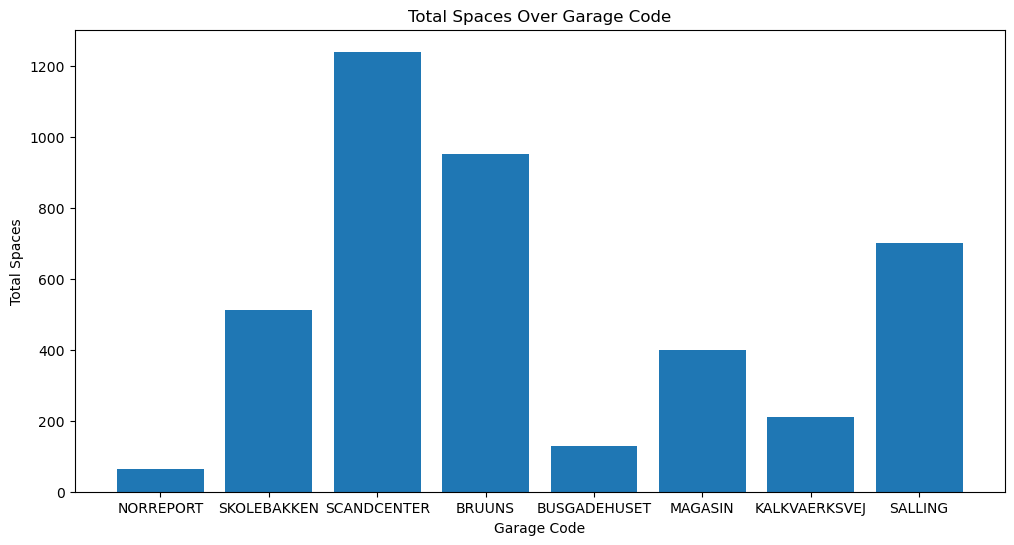

In [76]:
# Bar chart for 'totalspaces' over 'garagecode' use plt
plt.figure(figsize=(12, 6))
plt.bar(df['garagecode'], df['totalspaces'])
plt.title('Total Spaces Over Garage Code')
plt.xlabel('Garage Code')
plt.ylabel('Total Spaces')
plt.show()

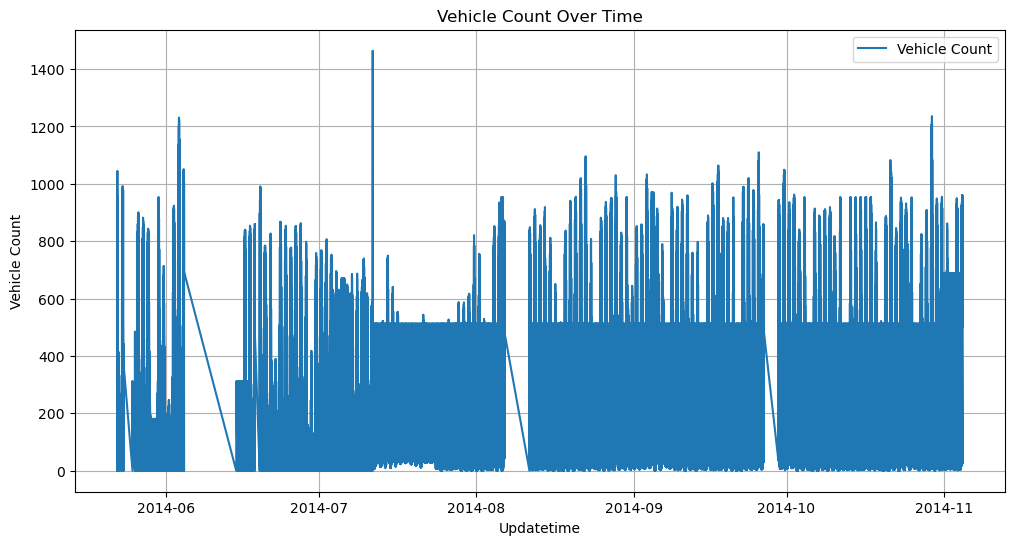

In [77]:
# Line plot of 'vehiclecount' over 'updatetime'
plt.figure(figsize=(12, 6))
plt.plot(df['updatetime'], df['vehiclecount'], label='Vehicle Count')
plt.title('Vehicle Count Over Time')
plt.xlabel('Updatetime')
plt.ylabel('Vehicle Count')
plt.legend()
plt.grid(True)
plt.show()

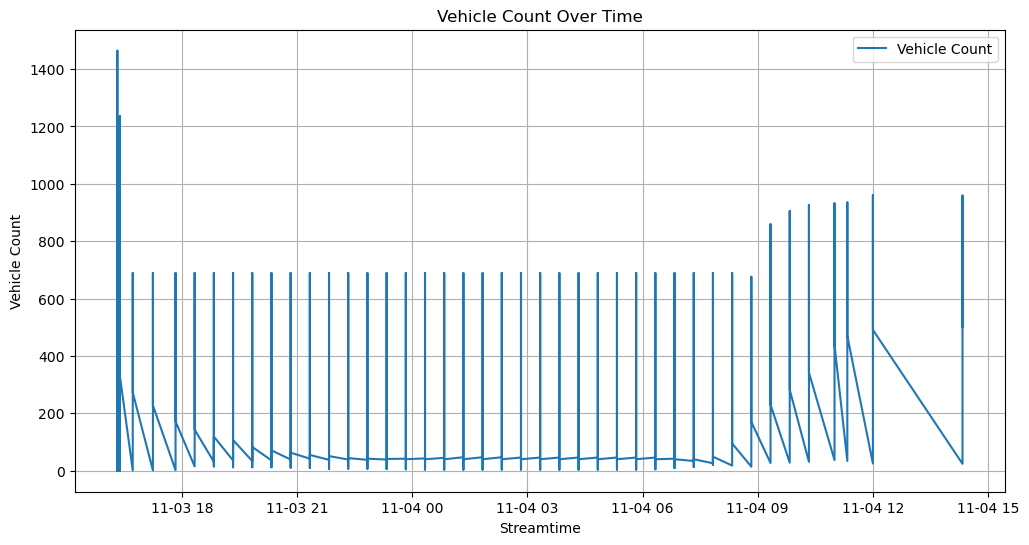

In [78]:
# Line plot of 'vehiclecount' over 'streamtime'
plt.figure(figsize=(12, 6))
plt.plot(df['streamtime'], df['vehiclecount'], label='Vehicle Count')
plt.title('Vehicle Count Over Time')
plt.xlabel('Streamtime')
plt.ylabel('Vehicle Count')
plt.legend()
plt.grid(True)
plt.show()

#### Conclusions 2
*  From the dataset description the difference between streamline and updatetime was not clear.
*  From the plots above we can see that we have more updatetime datapoints compared to the streamtime.
*  Let's check the difference between streamtime and updatetime.



In [79]:
# Get unique streamtime_values
unique_streamtime_values = df['streamtime'].unique()
print(f"Unique streamtime values: {unique_streamtime_values}")
print(f"Unique streamtime values length: {len(unique_streamtime_values)}")

Unique streamtime values: <DatetimeArray>
['2014-11-03 16:18:44', '2014-11-03 16:19:11', '2014-11-03 16:19:40',
 '2014-11-03 16:20:08', '2014-11-03 16:22:16', '2014-11-03 16:22:34',
 '2014-11-03 16:23:01', '2014-11-03 16:43:16', '2014-11-03 17:14:47',
 '2014-11-03 17:50:09', '2014-11-03 18:20:01', '2014-11-03 18:50:01',
 '2014-11-03 19:20:02', '2014-11-03 19:50:02', '2014-11-03 20:20:01',
 '2014-11-03 20:50:01', '2014-11-03 21:20:02', '2014-11-03 21:50:01',
 '2014-11-03 22:20:02', '2014-11-03 22:50:01', '2014-11-03 23:20:02',
 '2014-11-03 23:50:02', '2014-11-04 00:20:02', '2014-11-04 00:50:02',
 '2014-11-04 01:20:01', '2014-11-04 01:50:01', '2014-11-04 02:20:01',
 '2014-11-04 02:50:02', '2014-11-04 03:20:01', '2014-11-04 03:50:01',
 '2014-11-04 04:20:02', '2014-11-04 04:50:04', '2014-11-04 05:20:01',
 '2014-11-04 05:50:02', '2014-11-04 06:20:02', '2014-11-04 06:50:01',
 '2014-11-04 07:20:01', '2014-11-04 07:50:01', '2014-11-04 08:20:02',
 '2014-11-04 08:50:01', '2014-11-04 09:20:03', '

In [80]:
# Get the minimum 'streamtime'
min_streamtime = df['streamtime'].min()

# Get the maximum 'streamtime'
max_streamtime = df['streamtime'].max()

print(f"Minimum Streamtime: {min_streamtime}")
print(f"Maximum Streamtime: {max_streamtime}")

Minimum Streamtime: 2014-11-03 16:18:44
Maximum Streamtime: 2014-11-04 14:20:03


In [81]:
# Get the minimum 'updatetime'
min_updatetime = df['updatetime'].min()

# Get the maximum 'updatetime'
max_updatetime = df['updatetime'].max()

print(f"Minimum Update time: {min_updatetime}")
print(f"Maximum Update time: {max_updatetime}")

Minimum Update time: 2014-05-22 09:09:04.145000
Maximum Update time: 2014-11-04 14:13:47.581000


#### Conclusions 3
* Streamtime ranges between 2 dates 2014-11-03 and 2014-11-04
* These were the dates when the data uploaded to the server
* Updatetime ranges between dates 2014-05-22 and 2014-11-04
* These were the date times when the parking garages reported on the vehcile counts
* **We are interested in predictions based in the `updatetime`, and will not be using `streamtime`**
* From the plot of `vehcilecount` over the `updatetime`, it seemed that we had some missing dates in our data set. Let's explore.


In [82]:
# Find the minimum and maximum timestamps
min_timestamp = df['updatetime'].dt.date.min()
max_timestamp = df['updatetime'].dt.date.max()

# Generate a date range from the minimum to the maximum timestamp
expected_dates = pd.date_range(start=min_timestamp, end=max_timestamp, freq='D')
actual_dates = pd.to_datetime(df['updatetime'].dt.date.unique())


# Check for missing timestamps
missing_timestamps = expected_dates[~expected_dates.isin(actual_dates)]

missing_timestamps_df =  pd.DataFrame(missing_timestamps, columns=['missing_timestamps'])

if missing_timestamps.empty:
    print("No missing timestamps found.")
else:
    print("Missing timestamps found:")
    display(missing_timestamps_df.head(100))
    print(f"Total missing timestamps: {len(missing_timestamps)}")

Missing timestamps found:


missing_timestamps
0          2014-05-24
1          2014-06-05
2          2014-06-06
3          2014-06-07
4          2014-06-08
5          2014-06-09
6          2014-06-10
7          2014-06-11
8          2014-06-12
9          2014-06-13
10         2014-08-07
11         2014-08-08
12         2014-08-09
13         2014-08-10
14         2014-09-27
15         2014-09-28

Total missing timestamps: 16


count       mean         std       min      25%   50%  \
garagecode                                                              
BRUUNS         6907.0  34.652486  205.318242  0.000033  29.9999  30.0   
BUSGADEHUSET   6907.0  34.652486  205.318242  0.000033  29.9999  30.0   
KALKVAERKSVEJ  6907.0  34.652486  205.318242  0.000033  29.9999  30.0   
MAGASIN        6907.0  34.652486  205.318242  0.000033  29.9999  30.0   
NORREPORT      6907.0  34.652486  205.318242  0.000033  29.9999  30.0   
SALLING        6907.0  34.652486  205.318242  0.000033  29.9999  30.0   
SCANDCENTER    6907.0  34.652486  205.318242  0.000033  29.9999  30.0   
SKOLEBAKKEN    6907.0  34.652486  205.318242  0.000033  29.9999  30.0   

                   75%           max  
garagecode                            
BRUUNS         30.0001  14747.039983  
BUSGADEHUSET   30.0001  14747.039983  
KALKVAERKSVEJ  30.0001  14747.039983  
MAGASIN        30.0001  14747.039983  
NORREPORT      30.0001  14747.039983  
SALLING        30.0001  14747.039983  
SCANDCENTER    30.0001  14747.039983  
SKOLEBAKKEN    30.0001  14747.039983

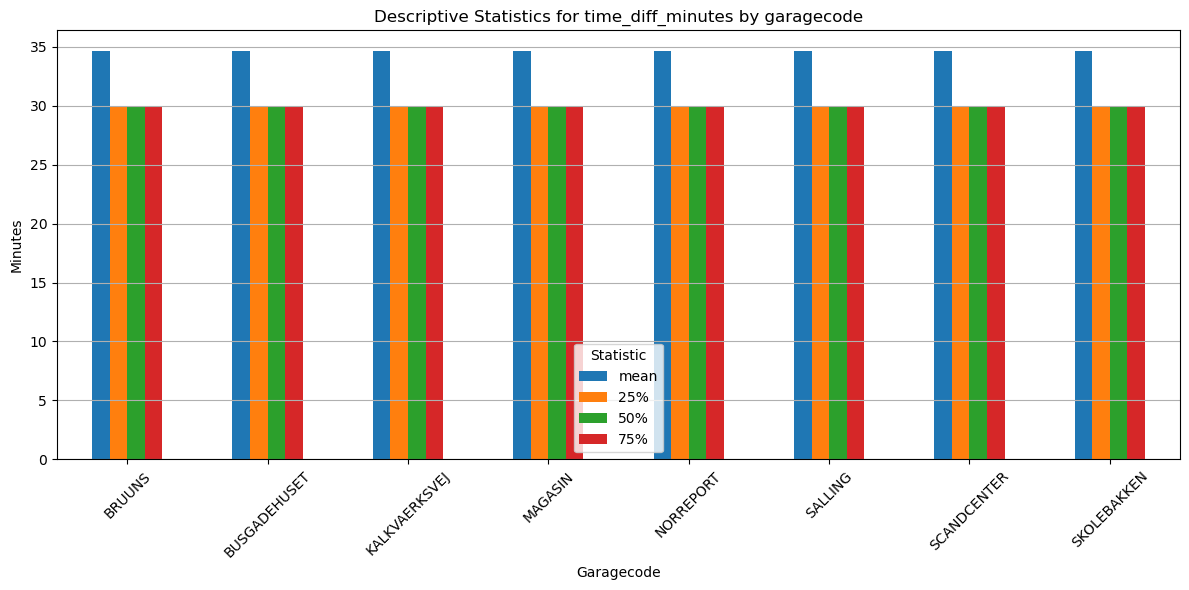

In [83]:
# Check the frequency of the reporting
df_diff = df.copy()

# Sort by garagecode and updatetime
df_diff = df_diff.sort_values(['garagecode', 'updatetime'])

# Calculate the time difference for each garagecode
df_diff['time_diff_minutes'] = df_diff.groupby('garagecode')['updatetime'].diff() / pd.Timedelta(minutes=1)

# Plot descriptive statistics for time_diff_minutes for each garagecode separately
garagecode_groups = df_diff.groupby('garagecode')['time_diff_minutes']
garagecode_stats = garagecode_groups.describe()

display(garagecode_stats)

# Plot boxplots
garagecode_stats[['mean', '25%', '50%', '75%']].plot(kind='bar', figsize=(12, 6))
plt.ylabel('Minutes')
plt.xlabel('Garagecode')
plt.title('Descriptive Statistics for time_diff_minutes by garagecode')
plt.xticks(rotation=45)
plt.legend(title='Statistic')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### Conclusions 4
* We have totla of **16 dates** missing from the dataset.
* For each garage most of the data is reported with the difference of **30 minutes**
* Let's also investigate what data was reported per each garage.

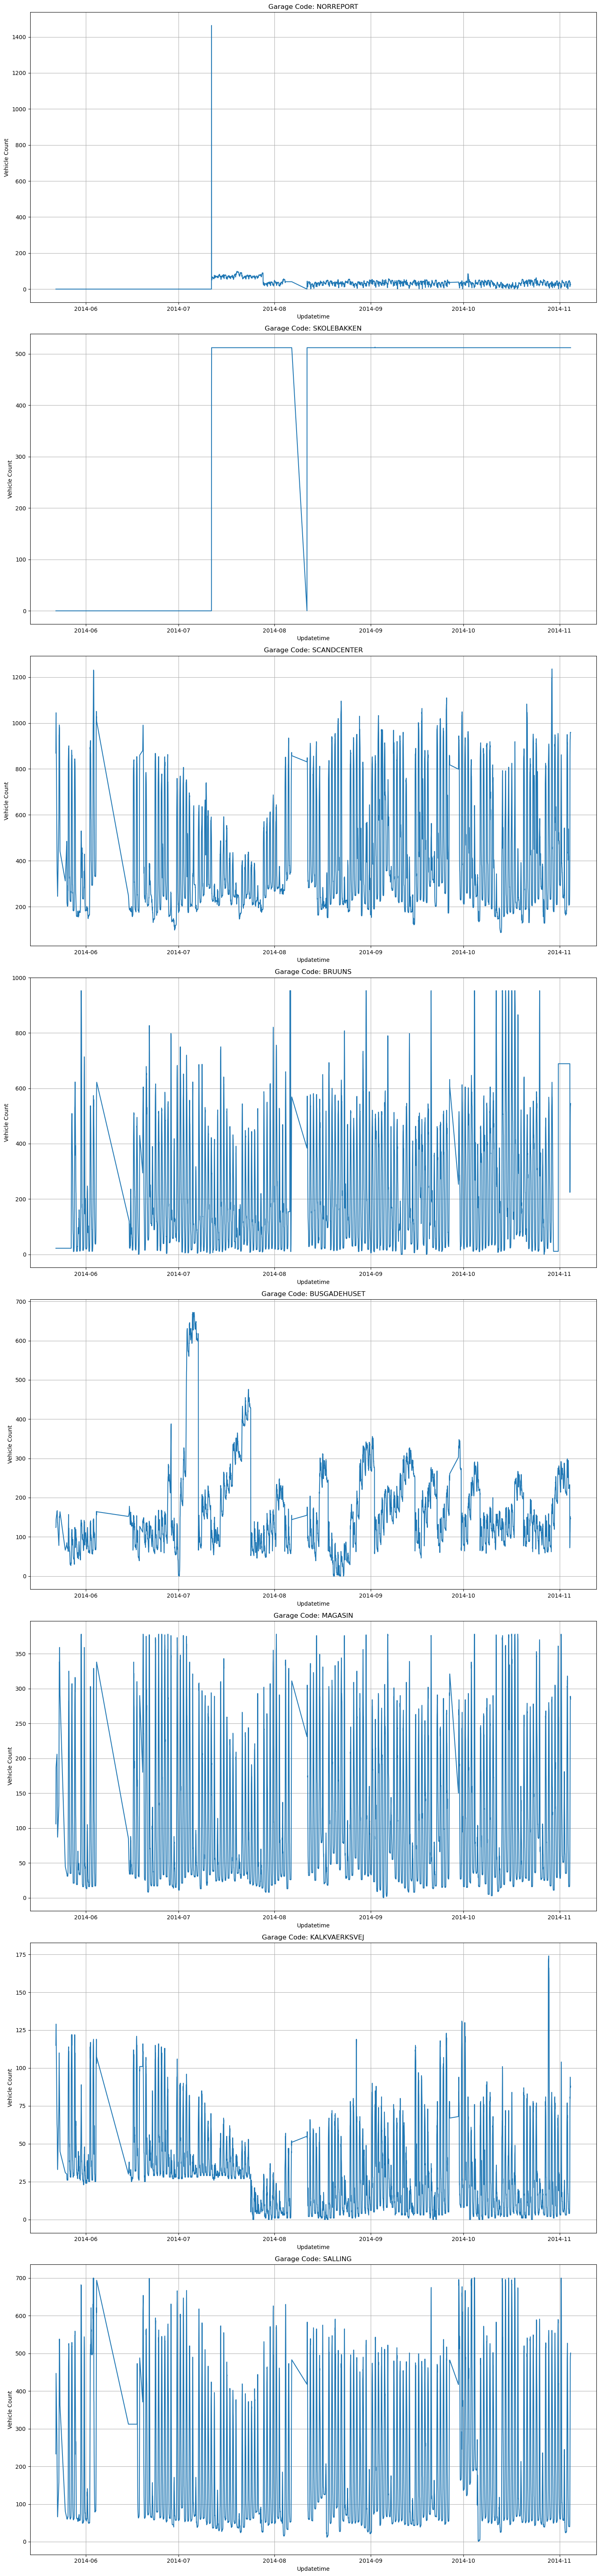

In [84]:
garage_codes = df['garagecode'].unique()

# Create subplots
fig, axes = plt.subplots(len(garage_codes), figsize=(15, 8*len(garage_codes)))

# Iterate through each garage code
for i, code in enumerate(garage_codes):
    # Filter dataframe for current garage code
    sub_df = df[df['garagecode'] == code]

    # Plot vehicle count against timestamp
    axes[i].plot(sub_df['updatetime'], sub_df['vehiclecount'])
    axes[i].set_title(f'Garage Code: {code}')
    axes[i].set_xlabel('Updatetime')
    axes[i].set_ylabel('Vehicle Count')
    axes[i].grid(True)

plt.tight_layout()
plt.show()

### Conclusions - EDA and Data Quality
-  We have **55264** entries in the dataset
- There is total of **16** missing dates when no `vehiclecount` was reported. This amounts to $\approx 768$ missing entries, since for every day the data is reported every 30 minutes.
- Looks like June and August and September have missing entries. Those missing entries are consistent across oll of the garage codes.
- Additionally, it seems there might be data quality issues per garage level:
  * SKOLEBAKKEN - was probably used for a company's vehicles parking or similar, since vehicle count did not change across multiple days
  * NORREPORT has 0 cars parked up to mid July, then an outlier day with 1400 parked, following days with under 200 cars parked
  * KALKVAERKSVEJ - up to mid July KALKVAERKSVEJ always had at least 25 cars parked permanently
  * Data for the remaining garages - SCANDCENTER, BRUUNS, BUSGADEHUSET and MAGASIN and SALLING looks to be in a good shape, besides the 16 missing dates

### Preprocessing the Dataset

Given the conclusion above, we decided to do the following preprocessing steps:

- Normalize data to increase model performance and prevent issues, such as gradient explosion and vanishing
- We will not be backfilling missing dates, since this will result in a loss of a temporal pattern, instead we will focus on efficiently using the existing data
- Every garage has slightly different patterns of occupancy depending on the date / time. From our predict perspective it makes sense to provide a Garage level APIs, thus we will be training models for each garage separately

In [86]:
# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))

### Creating the LSTM Model

In [87]:
# Set sequence length
sequence_length = 10

In [88]:
# Create a dictionary to hold the values to visualize
results = {}

In [89]:
for area_id, area_data in df.groupby('garagecode'):
    # Extracting only the occupancy values
    occupancy = area_data[['vehiclecount']]

    # Normalize the occupancy dataset
    occupancy_scaled = scaler.fit_transform(occupancy)

    # Create sequences and labels
    X, y = create_sequences(occupancy_scaled, sequence_length)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    # Define the LSTM model
    model = Sequential()
    model.add(Bidirectional(LSTM(64,input_shape=(sequence_length,1),return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(16)))
    model.add(Dropout(0.2))
    model.add(Dense(64,activation='linear'))
    model.add(Dropout(0.5))
    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('linear'))

    # Model Path
    model_path = "model_lstm.h5"

    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.05, verbose=2,
                    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                    keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

    # Evaluate the model
    train_loss = model.evaluate(X_train, y_train, verbose=0)
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    # Predict occupancy values on testing set
    y_test_pred = model.predict(X_test)

    # Inverse transform the predicted and actual values to their original scale
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, y_test_pred)

    # Store results in the dictionary
    results[area_id] = {
        'train_loss': train_loss,
        'test_loss': test_loss,
        'mae': mae,
        'loss': history.history['loss'],
        'val_loss': history.history['val_loss'],
        'y_test_pred': y_test_pred,
        'y_test': y_test
    }

Epoch 1/20
164/164 - 21s - loss: 0.0151 - val_loss: 0.0073 - 21s/epoch - 129ms/step
Epoch 2/20


/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 0.0057 - val_loss: 0.0099 - 7s/epoch - 40ms/step
Epoch 3/20
164/164 - 6s - loss: 0.0211 - val_loss: 0.0081 - 6s/epoch - 38ms/step
Epoch 4/20
164/164 - 6s - loss: 0.0071 - val_loss: 0.0214 - 6s/epoch - 37ms/step
Epoch 5/20
164/164 - 6s - loss: 0.0062 - val_loss: 0.0176 - 6s/epoch - 38ms/step
Epoch 6/20
164/164 - 7s - loss: 0.0159 - val_loss: 0.0181 - 7s/epoch - 40ms/step
Epoch 7/20
164/164 - 6s - loss: 0.0186 - val_loss: 0.0362 - 6s/epoch - 37ms/step
Epoch 8/20
164/164 - 6s - loss: 0.0187 - val_loss: 0.0398 - 6s/epoch - 38ms/step
Epoch 9/20
164/164 - 6s - loss: 0.0374 - val_loss: 0.0433 - 6s/epoch - 38ms/step
Epoch 10/20
164/164 - 6s - loss: 0.0430 - val_loss: 0.0119 - 6s/epoch - 37ms/step
Epoch 11/20
164/164 - 6s - loss: 0.0132 - val_loss: 0.0361 - 6s/epoch - 36ms/step
44/44 [==============================] - 2s 26ms/step
Epoch 1/20
164/164 - 17s - loss: 0.0070 - val_loss: 0.0016 - 17s/epoch - 104ms/step
Epoch 2/20


/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 0.0029 - val_loss: 0.0021 - 7s/epoch - 41ms/step
Epoch 3/20
164/164 - 6s - loss: 0.0023 - val_loss: 0.0013 - 6s/epoch - 38ms/step
Epoch 4/20
164/164 - 6s - loss: 0.0023 - val_loss: 8.6806e-04 - 6s/epoch - 38ms/step
Epoch 5/20
164/164 - 6s - loss: 0.0019 - val_loss: 7.5070e-04 - 6s/epoch - 37ms/step
Epoch 6/20
164/164 - 6s - loss: 0.0016 - val_loss: 0.0010 - 6s/epoch - 38ms/step
Epoch 7/20
164/164 - 6s - loss: 0.0018 - val_loss: 9.3426e-04 - 6s/epoch - 39ms/step
Epoch 8/20
164/164 - 6s - loss: 0.0017 - val_loss: 0.0013 - 6s/epoch - 37ms/step
Epoch 9/20
164/164 - 6s - loss: 0.0016 - val_loss: 0.0015 - 6s/epoch - 37ms/step
Epoch 10/20
164/164 - 6s - loss: 0.0016 - val_loss: 0.0015 - 6s/epoch - 39ms/step
Epoch 11/20
164/164 - 6s - loss: 0.0018 - val_loss: 0.0020 - 6s/epoch - 38ms/step
Epoch 12/20
164/164 - 6s - loss: 0.0016 - val_loss: 8.4152e-04 - 6s/epoch - 38ms/step
Epoch 13/20
164/164 - 7s - loss: 0.0014 - val_loss: 0.0013 - 7s/epoch - 40ms/step
Epoch 14/20
164/164

/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 0.0041 - val_loss: 0.0040 - 7s/epoch - 45ms/step
Epoch 3/20
164/164 - 6s - loss: 0.0050 - val_loss: 0.0077 - 6s/epoch - 39ms/step
Epoch 4/20
164/164 - 6s - loss: 0.0075 - val_loss: 0.0060 - 6s/epoch - 37ms/step
Epoch 5/20
164/164 - 6s - loss: 0.0047 - val_loss: 0.0072 - 6s/epoch - 37ms/step
Epoch 6/20
164/164 - 6s - loss: 0.0031 - val_loss: 0.0075 - 6s/epoch - 37ms/step
Epoch 7/20
164/164 - 7s - loss: 0.0025 - val_loss: 0.0031 - 7s/epoch - 41ms/step
Epoch 8/20
164/164 - 6s - loss: 0.0028 - val_loss: 0.0028 - 6s/epoch - 38ms/step
Epoch 9/20
164/164 - 6s - loss: 0.0039 - val_loss: 0.0055 - 6s/epoch - 38ms/step
Epoch 10/20
164/164 - 6s - loss: 0.0153 - val_loss: 0.0089 - 6s/epoch - 36ms/step
Epoch 11/20
164/164 - 6s - loss: 0.0116 - val_loss: 0.0119 - 6s/epoch - 38ms/step
Epoch 12/20
164/164 - 6s - loss: 0.0082 - val_loss: 0.0138 - 6s/epoch - 38ms/step
Epoch 13/20
164/164 - 6s - loss: 0.0074 - val_loss: 0.0039 - 6s/epoch - 39ms/step
Epoch 14/20
164/164 - 6s - loss: 0.

/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 0.0069 - val_loss: 0.0067 - 7s/epoch - 42ms/step
Epoch 3/20
164/164 - 6s - loss: 0.0072 - val_loss: 0.0047 - 6s/epoch - 39ms/step
Epoch 4/20
164/164 - 6s - loss: 0.0151 - val_loss: 0.0443 - 6s/epoch - 39ms/step
Epoch 5/20
164/164 - 6s - loss: 0.0306 - val_loss: 0.0088 - 6s/epoch - 38ms/step
Epoch 6/20
164/164 - 6s - loss: 0.0067 - val_loss: 0.0948 - 6s/epoch - 38ms/step
Epoch 7/20
164/164 - 6s - loss: 0.0168 - val_loss: 0.2988 - 6s/epoch - 37ms/step
Epoch 8/20
164/164 - 6s - loss: 0.0250 - val_loss: 0.1914 - 6s/epoch - 37ms/step
Epoch 9/20
164/164 - 6s - loss: 0.0215 - val_loss: 0.0039 - 6s/epoch - 37ms/step
Epoch 10/20
164/164 - 6s - loss: 0.0142 - val_loss: 0.0720 - 6s/epoch - 38ms/step
Epoch 11/20
164/164 - 6s - loss: 0.0112 - val_loss: 0.0847 - 6s/epoch - 37ms/step
44/44 [==============================] - 3s 29ms/step
Epoch 1/20
164/164 - 31s - loss: 0.0010 - val_loss: 0.0042 - 31s/epoch - 186ms/step
Epoch 2/20


/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 6.6901e-04 - val_loss: 0.0021 - 7s/epoch - 41ms/step
Epoch 3/20
164/164 - 6s - loss: 0.0013 - val_loss: 0.0123 - 6s/epoch - 39ms/step
Epoch 4/20
164/164 - 6s - loss: 7.1890e-04 - val_loss: 0.0056 - 6s/epoch - 39ms/step
Epoch 5/20
164/164 - 6s - loss: 4.0186e-04 - val_loss: 0.0093 - 6s/epoch - 37ms/step
Epoch 6/20
164/164 - 6s - loss: 3.7431e-04 - val_loss: 0.0050 - 6s/epoch - 38ms/step
Epoch 7/20
164/164 - 6s - loss: 9.7034e-04 - val_loss: 0.0035 - 6s/epoch - 37ms/step
Epoch 8/20
164/164 - 6s - loss: 8.5882e-04 - val_loss: 0.0033 - 6s/epoch - 37ms/step
Epoch 9/20
164/164 - 7s - loss: 4.3762e-04 - val_loss: 0.0077 - 7s/epoch - 43ms/step
Epoch 10/20
164/164 - 6s - loss: 3.1008e-04 - val_loss: 0.0076 - 6s/epoch - 38ms/step
Epoch 11/20
164/164 - 6s - loss: 7.5453e-04 - val_loss: 0.0063 - 6s/epoch - 38ms/step
Epoch 12/20
164/164 - 6s - loss: 3.1697e-04 - val_loss: 0.0083 - 6s/epoch - 38ms/step
44/44 [==============================] - 5s 45ms/step
Epoch 1/20
164/164 - 27

/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 0.0078 - val_loss: 0.0255 - 7s/epoch - 43ms/step
Epoch 3/20
164/164 - 8s - loss: 0.0111 - val_loss: 0.0277 - 8s/epoch - 47ms/step
Epoch 4/20
164/164 - 9s - loss: 0.0066 - val_loss: 0.0155 - 9s/epoch - 54ms/step
Epoch 5/20
164/164 - 12s - loss: 0.0087 - val_loss: 0.0344 - 12s/epoch - 76ms/step
Epoch 6/20
164/164 - 8s - loss: 0.0130 - val_loss: 0.0114 - 8s/epoch - 47ms/step
Epoch 7/20
164/164 - 7s - loss: 0.0166 - val_loss: 0.0078 - 7s/epoch - 41ms/step
Epoch 8/20
164/164 - 7s - loss: 0.0139 - val_loss: 0.0087 - 7s/epoch - 40ms/step
Epoch 9/20
164/164 - 8s - loss: 0.0105 - val_loss: 0.0181 - 8s/epoch - 47ms/step
Epoch 10/20
164/164 - 7s - loss: 0.0142 - val_loss: 0.0238 - 7s/epoch - 45ms/step
Epoch 11/20
164/164 - 7s - loss: 0.0209 - val_loss: 0.0334 - 7s/epoch - 42ms/step
Epoch 12/20
164/164 - 8s - loss: 0.0137 - val_loss: 0.0144 - 8s/epoch - 48ms/step
Epoch 13/20
164/164 - 7s - loss: 0.0041 - val_loss: 0.0134 - 7s/epoch - 42ms/step
Epoch 14/20
164/164 - 7s - loss: 

/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 0.0163 - val_loss: 0.0109 - 7s/epoch - 43ms/step
Epoch 3/20
164/164 - 7s - loss: 0.0193 - val_loss: 0.0066 - 7s/epoch - 42ms/step
Epoch 4/20
164/164 - 8s - loss: 0.0129 - val_loss: 0.0075 - 8s/epoch - 50ms/step
Epoch 5/20
164/164 - 6s - loss: 0.0141 - val_loss: 0.0138 - 6s/epoch - 37ms/step
Epoch 6/20
164/164 - 6s - loss: 0.0701 - val_loss: 0.0168 - 6s/epoch - 36ms/step
Epoch 7/20
164/164 - 6s - loss: 0.0171 - val_loss: 0.0184 - 6s/epoch - 38ms/step
Epoch 8/20
164/164 - 7s - loss: 0.0229 - val_loss: 0.0049 - 7s/epoch - 43ms/step
Epoch 9/20
164/164 - 6s - loss: 0.0085 - val_loss: 0.0031 - 6s/epoch - 38ms/step
Epoch 10/20
164/164 - 6s - loss: 0.0060 - val_loss: 0.0175 - 6s/epoch - 38ms/step
Epoch 11/20
164/164 - 7s - loss: 0.0058 - val_loss: 0.0210 - 7s/epoch - 41ms/step
Epoch 12/20
164/164 - 6s - loss: 0.0190 - val_loss: 0.0600 - 6s/epoch - 36ms/step
Epoch 13/20
164/164 - 6s - loss: 0.0236 - val_loss: 0.0512 - 6s/epoch - 37ms/step
Epoch 14/20
164/164 - 6s - loss: 0.

/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 0.0015 - val_loss: 0.0011 - 7s/epoch - 42ms/step
Epoch 3/20
164/164 - 7s - loss: 0.0012 - val_loss: 0.0010 - 7s/epoch - 40ms/step
Epoch 4/20
164/164 - 7s - loss: 0.0012 - val_loss: 9.6237e-04 - 7s/epoch - 41ms/step
Epoch 5/20
164/164 - 6s - loss: 8.9916e-04 - val_loss: 0.0011 - 6s/epoch - 39ms/step
Epoch 6/20
164/164 - 6s - loss: 0.0017 - val_loss: 1.3481e-04 - 6s/epoch - 38ms/step
Epoch 7/20
164/164 - 6s - loss: 0.0019 - val_loss: 5.1447e-04 - 6s/epoch - 38ms/step
Epoch 8/20
164/164 - 15s - loss: 0.0020 - val_loss: 2.4903e-05 - 15s/epoch - 91ms/step
Epoch 9/20
164/164 - 6s - loss: 0.0013 - val_loss: 2.5799e-04 - 6s/epoch - 38ms/step
Epoch 10/20
164/164 - 7s - loss: 0.0012 - val_loss: 5.0018e-04 - 7s/epoch - 40ms/step
Epoch 11/20
164/164 - 6s - loss: 9.8770e-04 - val_loss: 1.3661e-04 - 6s/epoch - 39ms/step
Epoch 12/20
164/164 - 6s - loss: 8.2273e-04 - val_loss: 5.9222e-04 - 6s/epoch - 38ms/step
Epoch 13/20
164/164 - 7s - loss: 9.6942e-04 - val_loss: 1.1432e-04 - 7s

In [90]:
def visualize_model(y_test, y_pred, num_samples=500):
    # Actual data
    last_n_actual = y_test[-num_samples:]
    plt.figure(figsize=(12, 6))
    plt.plot(last_n_actual, label='Actual')
    # Predicted data
    last_n_predicted = y_pred[-num_samples:]
    plt.plot(last_n_predicted, label='Predicted')
    plt.title('Actual vs Predicted Vehicle Count')
    plt.xlabel('Index')
    plt.ylabel('Vehicle Count')
    plt.legend()
    plt.show()


In [91]:
def visualize_loss(loss, val_loss):
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    print()


Parking Area: BRUUNS
Train Loss: 0.027039937674999237
Test Loss: 0.042578406631946564
MAE: 140.03030830051588



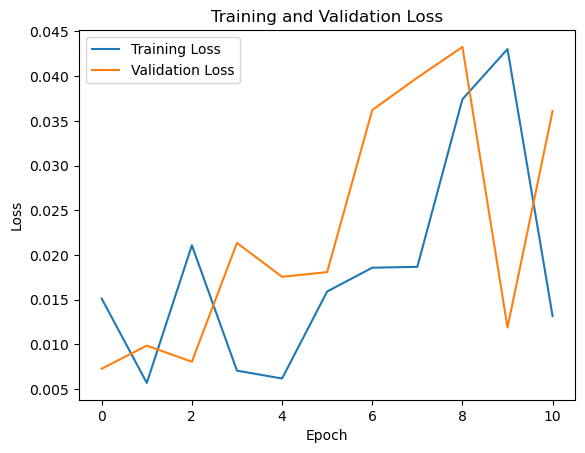

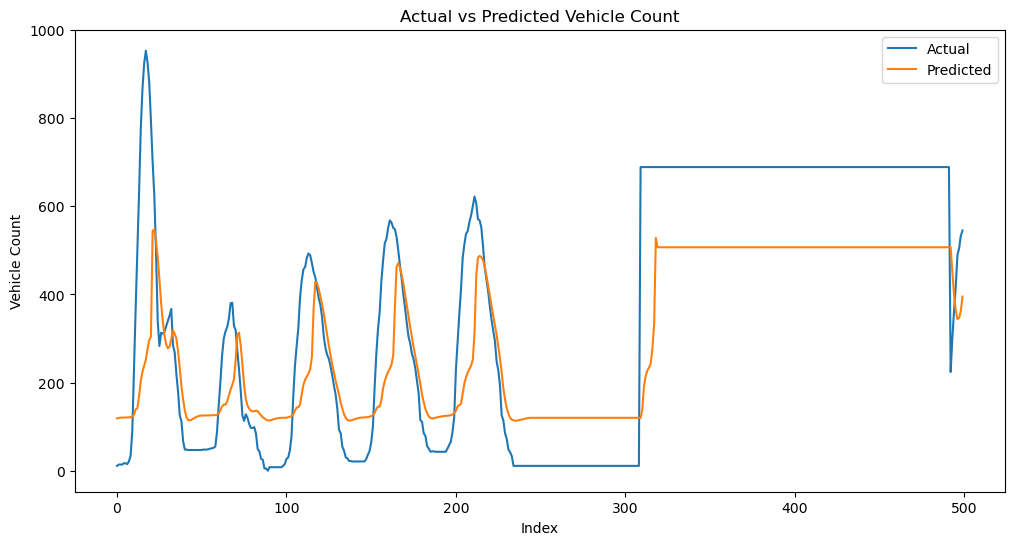

Parking Area: BUSGADEHUSET
Train Loss: 0.0016828645020723343
Test Loss: 0.0012969761155545712
MAE: 21.165626874177352



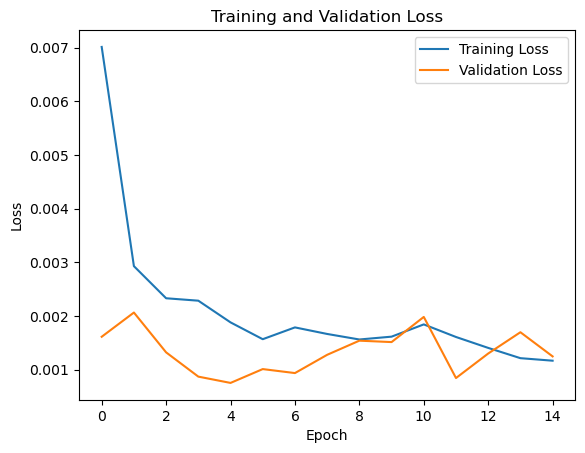

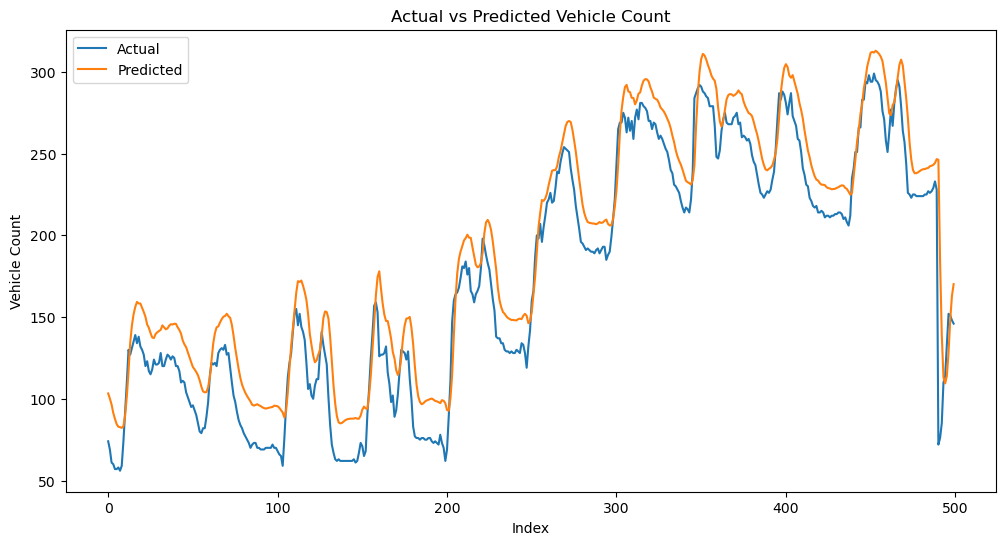

Parking Area: KALKVAERKSVEJ
Train Loss: 0.004140314646065235
Test Loss: 0.005991010926663876
MAE: 9.891131630496702



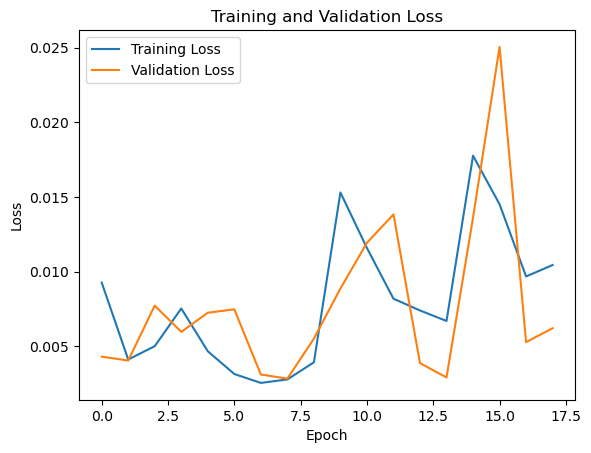

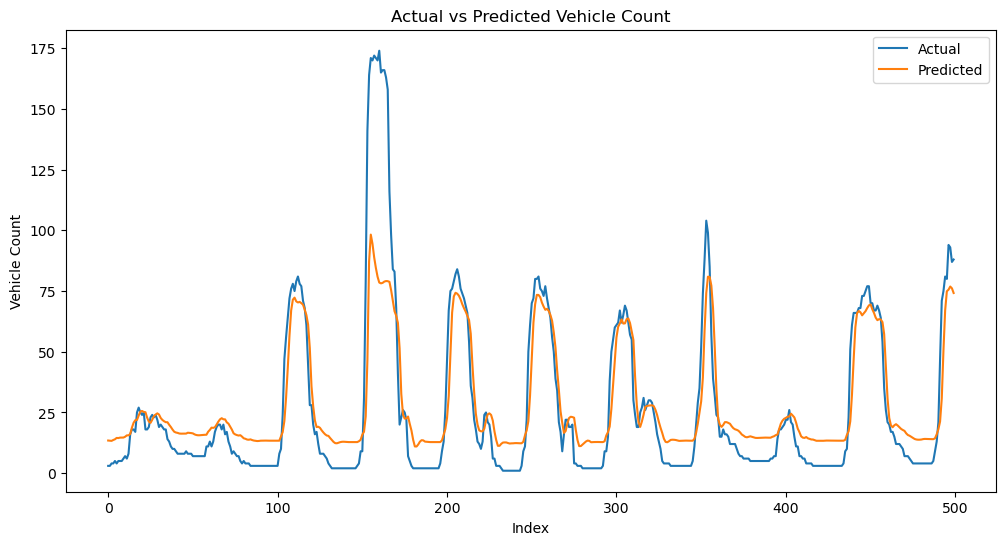

Parking Area: MAGASIN
Train Loss: 0.08427707105875015
Test Loss: 0.08309940248727798
MAE: 93.17207041204624



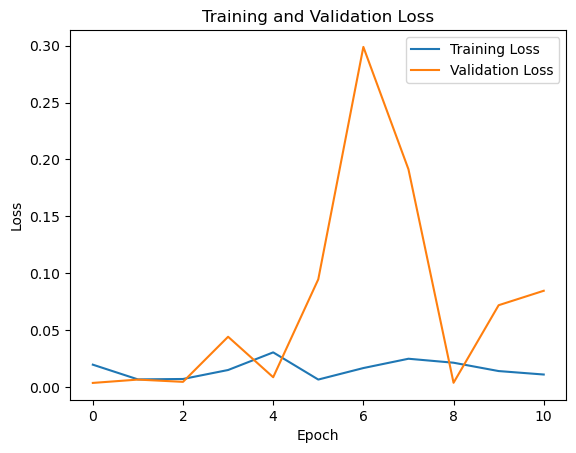

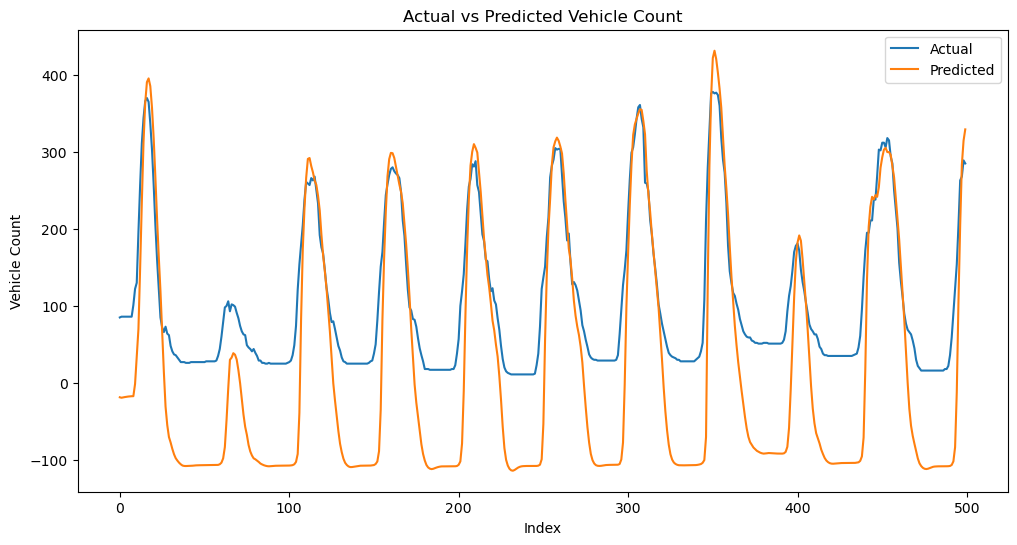

Parking Area: NORREPORT
Train Loss: 0.008291160687804222
Test Loss: 0.008081809617578983
MAE: 131.3723039654718



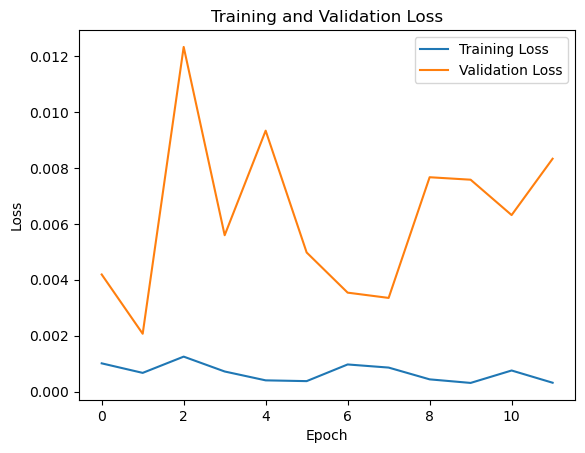

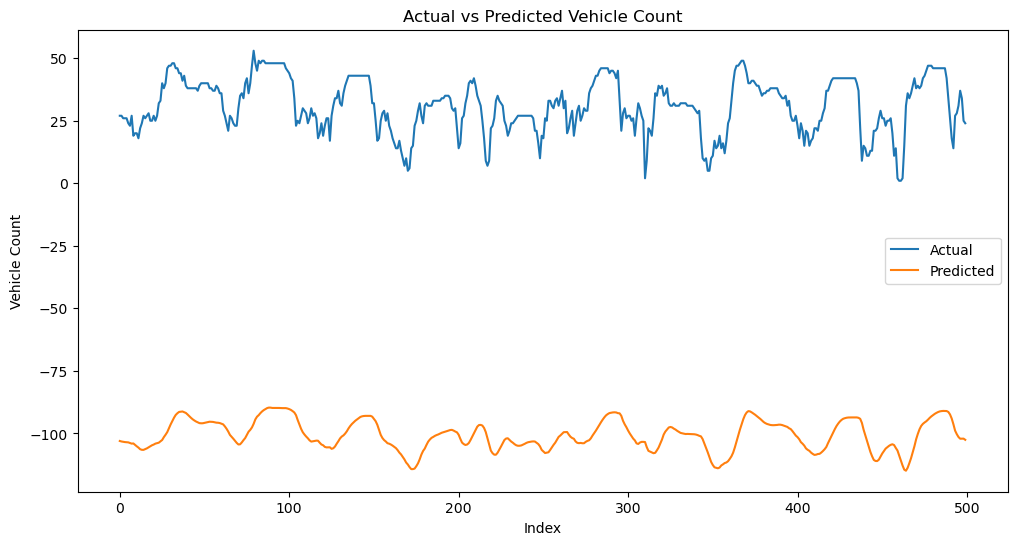

Parking Area: SALLING
Train Loss: 0.006595633924007416
Test Loss: 0.0059807924553751945
MAE: 42.602102019778194



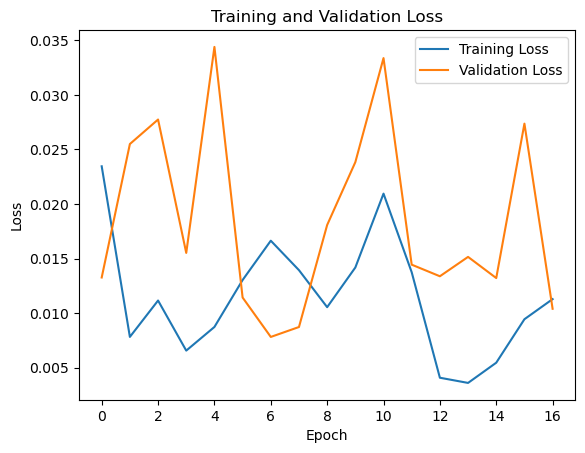

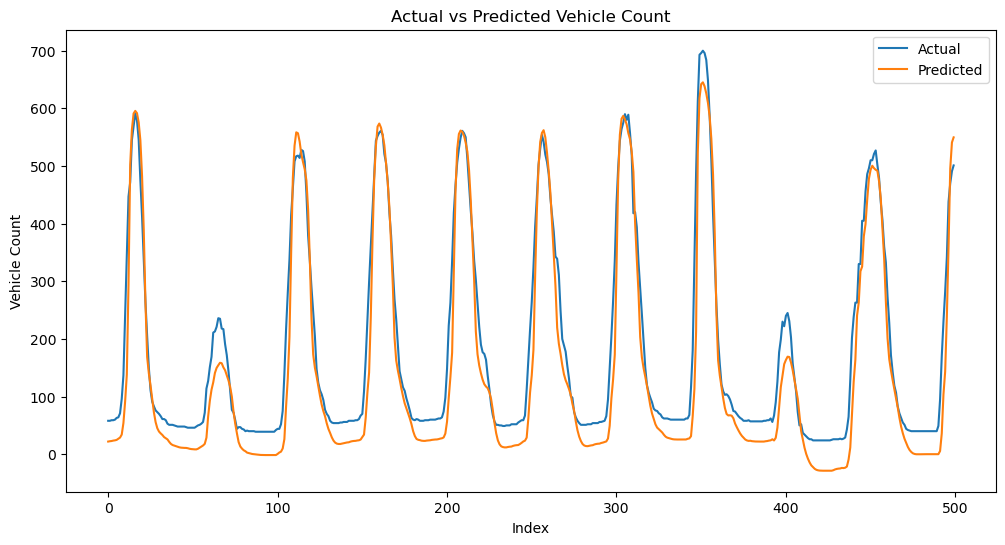

Parking Area: SCANDCENTER
Train Loss: 0.014675114303827286
Test Loss: 0.014928326942026615
MAE: 97.48193927709607



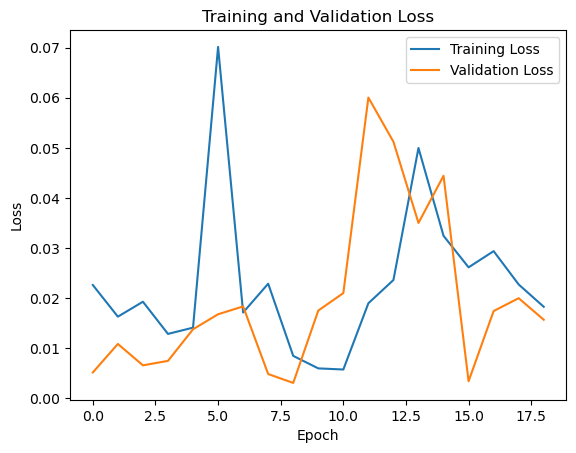

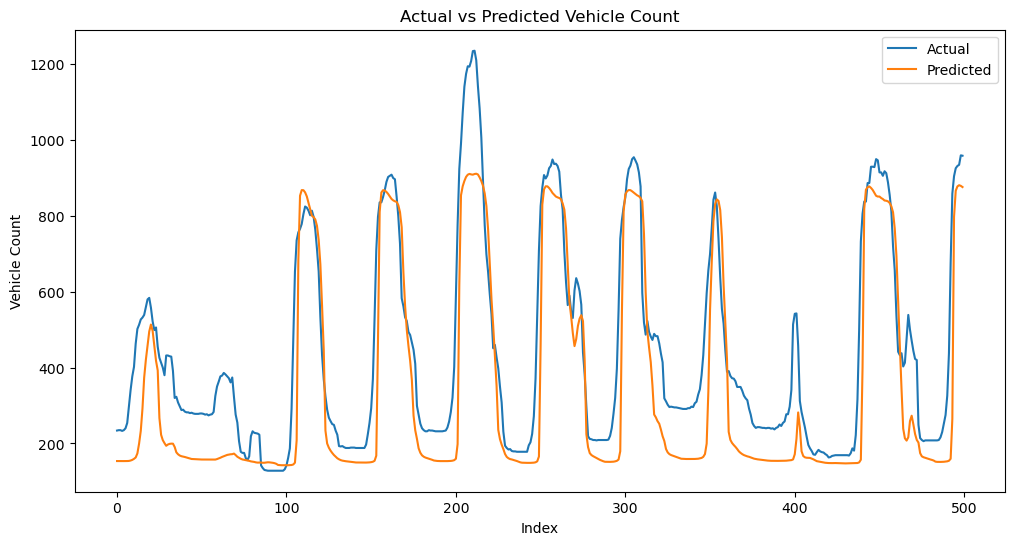

Parking Area: SKOLEBAKKEN
Train Loss: 0.024254340678453445
Test Loss: 0.000545378599781543
MAE: 11.980285821444747



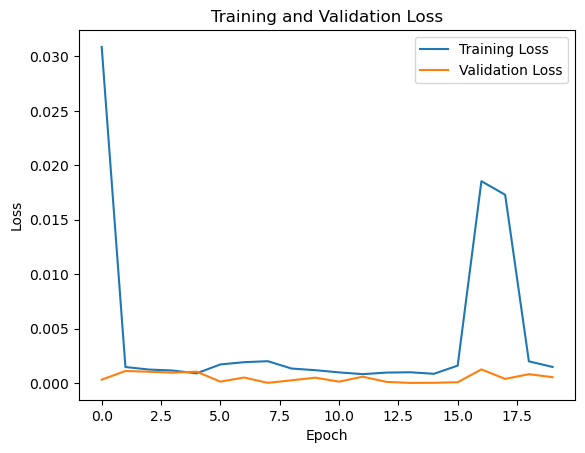

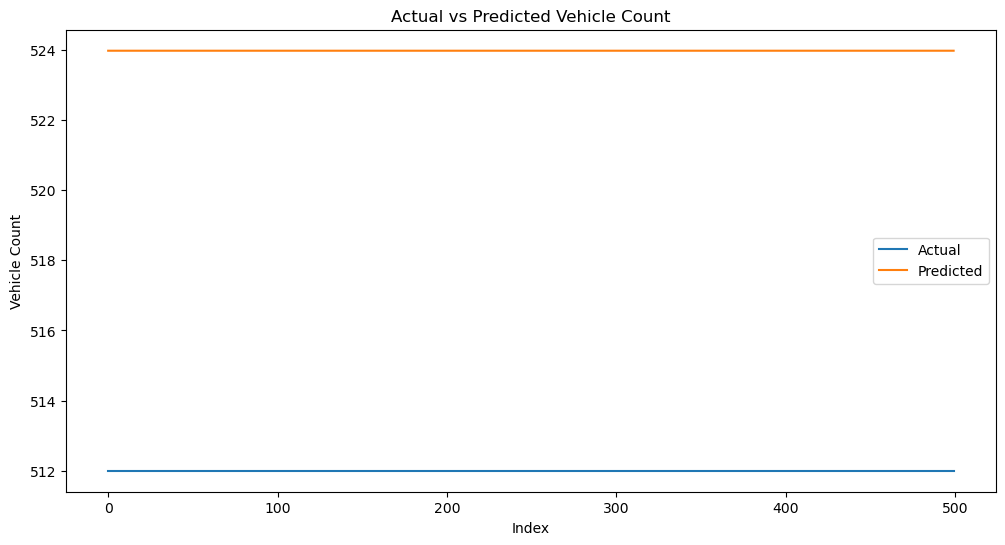

In [92]:
# Print results
for area_id, result in results.items():
    print(f"Parking Area: {area_id}")
    print(f"Train Loss: {result['train_loss']}")
    print(f"Test Loss: {result['test_loss']}")
    print(f"MAE: {result['mae']}")
    print()
    # Plot training and validation loss
    visualize_loss(result['loss'], result['val_loss'])
    # Plot actual vs predicted vehicle count
    visualize_model(result['y_test'], result['y_test_pred'])

### Creating the RNN Model

In [93]:
# Basing off the LSTM Model
# Create the results dictionary to store the RNN results
rnn_results = {}

In [94]:
for area_id, area_data in df.groupby('garagecode'):
    # Extracting only the occupancy values
    occupancy = area_data[['vehiclecount']]

    # Normalize the occupancy dataset
    occupancy_scaled = scaler.fit_transform(occupancy)

    # Create sequences and labels
    X, y = create_sequences(occupancy_scaled, sequence_length)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

    print("Number of samples in X_train:", len(X_train))
    print("Number of samples in y_train:", len(y_train))
    print("Number of samples in X_train:", X_test.shape)
    print("Number of samples in y_train:", y_test.shape)
    # # Define the RNN model
    model = Sequential()
    model.add(SimpleRNN(2,input_shape=(sequence_length,1),return_sequences=True))
    model.add(TimeDistributed(Dense(units=1, activation='linear')))
    model.add(GlobalAveragePooling1D())
    model.compile(optimizer='adam', loss='mean_squared_error')


    # Model Path
    model_path = "model_rnn.h5"

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.05, verbose=2,
                    callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                    keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])


    # Evaluate the model
    train_loss = model.evaluate(X_train, y_train, verbose=0)
    test_loss = model.evaluate(X_test, y_test, verbose=0)

    print("Number of samples in train_loss:", train_loss)
    print("Number of samples in test_loss:", test_loss)


    # Predict occupancy values on testing set
    y_test_pred = model.predict(X_test)

    print("Number of samples in y_test_pred:", len(y_test_pred))

    # Inverse transform the predicted and actual values to their original scale
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    y_test_pred = scaler.inverse_transform(y_test_pred.reshape(-1, 1)).flatten()

    print("Number of samples in y_test:", len(y_test))
    print("Number of samples in y_test_pred:", len(y_test_pred))

    # Calculate Mean Absolute Error (MAE)
    mae = mean_absolute_error(y_test, y_test_pred)

    # Store results in the dictionary
    rnn_results[area_id] = {
        'train_loss': train_loss,
        'test_loss': test_loss,
        'mae': mae,
        'loss':history.history['loss'],
        'val_loss':history.history['val_loss'],
        'y_test_pred': y_test_pred,
        'y_test': y_test
    }

Number of samples in X_train: 5518
Number of samples in y_train: 5518
Number of samples in X_train: (1380, 10, 1)
Number of samples in y_train: (1380, 1)
Epoch 1/20
164/164 - 10s - loss: 0.3949 - val_loss: 0.3318 - 10s/epoch - 59ms/step
Epoch 2/20


/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 0.1752 - val_loss: 0.1830 - 7s/epoch - 43ms/step
Epoch 3/20
164/164 - 7s - loss: 0.1076 - val_loss: 0.1181 - 7s/epoch - 42ms/step
Epoch 4/20
164/164 - 7s - loss: 0.0713 - val_loss: 0.0778 - 7s/epoch - 42ms/step
Epoch 5/20
164/164 - 7s - loss: 0.0474 - val_loss: 0.0521 - 7s/epoch - 41ms/step
Epoch 6/20
164/164 - 7s - loss: 0.0338 - val_loss: 0.0410 - 7s/epoch - 44ms/step
Epoch 7/20
164/164 - 7s - loss: 0.0290 - val_loss: 0.0384 - 7s/epoch - 45ms/step
Epoch 8/20
164/164 - 7s - loss: 0.0279 - val_loss: 0.0371 - 7s/epoch - 42ms/step
Epoch 9/20
164/164 - 7s - loss: 0.0272 - val_loss: 0.0359 - 7s/epoch - 40ms/step
Epoch 10/20
164/164 - 6s - loss: 0.0267 - val_loss: 0.0352 - 6s/epoch - 40ms/step
Epoch 11/20
164/164 - 6s - loss: 0.0260 - val_loss: 0.0343 - 6s/epoch - 39ms/step
Epoch 12/20
164/164 - 6s - loss: 0.0252 - val_loss: 0.0333 - 6s/epoch - 38ms/step
Epoch 13/20
164/164 - 7s - loss: 0.0239 - val_loss: 0.0305 - 7s/epoch - 41ms/step
Epoch 14/20
164/164 - 6s - loss: 0.

/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 0.0467 - val_loss: 0.0101 - 7s/epoch - 42ms/step
Epoch 3/20
164/164 - 7s - loss: 0.0334 - val_loss: 0.0065 - 7s/epoch - 41ms/step
Epoch 4/20
164/164 - 7s - loss: 0.0232 - val_loss: 0.0043 - 7s/epoch - 42ms/step
Epoch 5/20
164/164 - 7s - loss: 0.0168 - val_loss: 0.0035 - 7s/epoch - 41ms/step
Epoch 6/20
164/164 - 7s - loss: 0.0126 - val_loss: 0.0034 - 7s/epoch - 40ms/step
Epoch 7/20
164/164 - 7s - loss: 0.0094 - val_loss: 0.0032 - 7s/epoch - 41ms/step
Epoch 8/20
164/164 - 7s - loss: 0.0069 - val_loss: 0.0029 - 7s/epoch - 43ms/step
Epoch 9/20
164/164 - 10s - loss: 0.0050 - val_loss: 0.0023 - 10s/epoch - 58ms/step
Epoch 10/20
164/164 - 8s - loss: 0.0038 - val_loss: 0.0019 - 8s/epoch - 51ms/step
Epoch 11/20
164/164 - 8s - loss: 0.0031 - val_loss: 0.0017 - 8s/epoch - 49ms/step
Epoch 12/20
164/164 - 7s - loss: 0.0028 - val_loss: 0.0017 - 7s/epoch - 42ms/step
Epoch 13/20
164/164 - 7s - loss: 0.0026 - val_loss: 0.0017 - 7s/epoch - 42ms/step
Epoch 14/20
164/164 - 7s - loss: 

/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 0.0106 - val_loss: 0.0142 - 7s/epoch - 42ms/step
Epoch 3/20
164/164 - 7s - loss: 0.0093 - val_loss: 0.0138 - 7s/epoch - 43ms/step
Epoch 4/20
164/164 - 8s - loss: 0.0090 - val_loss: 0.0137 - 8s/epoch - 50ms/step
Epoch 5/20
164/164 - 7s - loss: 0.0088 - val_loss: 0.0135 - 7s/epoch - 43ms/step
Epoch 6/20
164/164 - 7s - loss: 0.0086 - val_loss: 0.0132 - 7s/epoch - 45ms/step
Epoch 7/20
164/164 - 7s - loss: 0.0085 - val_loss: 0.0131 - 7s/epoch - 42ms/step
Epoch 8/20
164/164 - 7s - loss: 0.0083 - val_loss: 0.0128 - 7s/epoch - 40ms/step
Epoch 9/20
164/164 - 8s - loss: 0.0081 - val_loss: 0.0125 - 8s/epoch - 46ms/step
Epoch 10/20
164/164 - 8s - loss: 0.0079 - val_loss: 0.0124 - 8s/epoch - 48ms/step
Epoch 11/20
164/164 - 7s - loss: 0.0077 - val_loss: 0.0121 - 7s/epoch - 41ms/step
Epoch 12/20
164/164 - 7s - loss: 0.0074 - val_loss: 0.0116 - 7s/epoch - 41ms/step
Epoch 13/20
164/164 - 7s - loss: 0.0072 - val_loss: 0.0115 - 7s/epoch - 41ms/step
Epoch 14/20
164/164 - 7s - loss: 0.

/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 8s - loss: 0.0513 - val_loss: 0.0483 - 8s/epoch - 51ms/step
Epoch 3/20
164/164 - 8s - loss: 0.0455 - val_loss: 0.0444 - 8s/epoch - 46ms/step
Epoch 4/20
164/164 - 7s - loss: 0.0424 - val_loss: 0.0422 - 7s/epoch - 44ms/step
Epoch 5/20
164/164 - 7s - loss: 0.0405 - val_loss: 0.0407 - 7s/epoch - 41ms/step
Epoch 6/20
164/164 - 7s - loss: 0.0393 - val_loss: 0.0397 - 7s/epoch - 40ms/step
Epoch 7/20
164/164 - 7s - loss: 0.0384 - val_loss: 0.0389 - 7s/epoch - 42ms/step
Epoch 8/20
164/164 - 7s - loss: 0.0376 - val_loss: 0.0382 - 7s/epoch - 41ms/step
Epoch 9/20
164/164 - 7s - loss: 0.0370 - val_loss: 0.0378 - 7s/epoch - 40ms/step
Epoch 10/20
164/164 - 7s - loss: 0.0366 - val_loss: 0.0373 - 7s/epoch - 40ms/step
Epoch 11/20
164/164 - 7s - loss: 0.0362 - val_loss: 0.0370 - 7s/epoch - 41ms/step
Epoch 12/20
164/164 - 7s - loss: 0.0359 - val_loss: 0.0367 - 7s/epoch - 41ms/step
Epoch 13/20
164/164 - 6s - loss: 0.0356 - val_loss: 0.0364 - 6s/epoch - 39ms/step
Epoch 14/20
164/164 - 6s - loss: 0.

/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 2.2675e-04 - val_loss: 8.8931e-05 - 7s/epoch - 43ms/step
Epoch 3/20
164/164 - 7s - loss: 2.2695e-04 - val_loss: 6.0403e-05 - 7s/epoch - 43ms/step
Epoch 4/20
164/164 - 7s - loss: 2.2546e-04 - val_loss: 5.9045e-05 - 7s/epoch - 43ms/step
Epoch 5/20
164/164 - 7s - loss: 2.2458e-04 - val_loss: 5.8255e-05 - 7s/epoch - 41ms/step
Epoch 6/20
164/164 - 7s - loss: 2.2475e-04 - val_loss: 5.8282e-05 - 7s/epoch - 40ms/step
Epoch 7/20
164/164 - 6s - loss: 2.2488e-04 - val_loss: 5.8968e-05 - 6s/epoch - 39ms/step
Epoch 8/20
164/164 - 7s - loss: 2.2350e-04 - val_loss: 8.0224e-05 - 7s/epoch - 41ms/step
Epoch 9/20
164/164 - 6s - loss: 2.2457e-04 - val_loss: 6.5675e-05 - 6s/epoch - 39ms/step
Epoch 10/20
164/164 - 7s - loss: 2.2371e-04 - val_loss: 5.4959e-05 - 7s/epoch - 40ms/step
Epoch 11/20
164/164 - 8s - loss: 2.2208e-04 - val_loss: 5.5571e-05 - 8s/epoch - 46ms/step
Epoch 12/20
164/164 - 7s - loss: 2.2230e-04 - val_loss: 5.6708e-05 - 7s/epoch - 41ms/step
Epoch 13/20
164/164 - 7s - lo

/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 0.1082 - val_loss: 0.1704 - 7s/epoch - 41ms/step
Epoch 3/20
164/164 - 7s - loss: 0.0845 - val_loss: 0.1373 - 7s/epoch - 40ms/step
Epoch 4/20
164/164 - 7s - loss: 0.0760 - val_loss: 0.1231 - 7s/epoch - 43ms/step
Epoch 5/20
164/164 - 7s - loss: 0.0712 - val_loss: 0.1151 - 7s/epoch - 40ms/step
Epoch 6/20
164/164 - 7s - loss: 0.0679 - val_loss: 0.1095 - 7s/epoch - 40ms/step
Epoch 7/20
164/164 - 7s - loss: 0.0656 - val_loss: 0.1057 - 7s/epoch - 40ms/step
Epoch 8/20
164/164 - 7s - loss: 0.0639 - val_loss: 0.1034 - 7s/epoch - 40ms/step
Epoch 9/20
164/164 - 7s - loss: 0.0625 - val_loss: 0.1016 - 7s/epoch - 40ms/step
Epoch 10/20
164/164 - 7s - loss: 0.0614 - val_loss: 0.1003 - 7s/epoch - 41ms/step
Epoch 11/20
164/164 - 6s - loss: 0.0605 - val_loss: 0.0982 - 6s/epoch - 39ms/step
Epoch 12/20
164/164 - 7s - loss: 0.0597 - val_loss: 0.0966 - 7s/epoch - 41ms/step
Epoch 13/20
164/164 - 7s - loss: 0.0589 - val_loss: 0.0952 - 7s/epoch - 40ms/step
Epoch 14/20
164/164 - 7s - loss: 0.

/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 0.0267 - val_loss: 0.0276 - 7s/epoch - 42ms/step
Epoch 3/20
164/164 - 7s - loss: 0.0223 - val_loss: 0.0235 - 7s/epoch - 41ms/step
Epoch 4/20
164/164 - 7s - loss: 0.0190 - val_loss: 0.0203 - 7s/epoch - 42ms/step
Epoch 5/20
164/164 - 7s - loss: 0.0165 - val_loss: 0.0179 - 7s/epoch - 41ms/step
Epoch 6/20
164/164 - 7s - loss: 0.0148 - val_loss: 0.0164 - 7s/epoch - 40ms/step
Epoch 7/20
164/164 - 6s - loss: 0.0140 - val_loss: 0.0156 - 6s/epoch - 40ms/step
Epoch 8/20
164/164 - 7s - loss: 0.0135 - val_loss: 0.0150 - 7s/epoch - 41ms/step
Epoch 9/20
164/164 - 7s - loss: 0.0132 - val_loss: 0.0146 - 7s/epoch - 41ms/step
Epoch 10/20
164/164 - 7s - loss: 0.0128 - val_loss: 0.0141 - 7s/epoch - 41ms/step
Epoch 11/20
164/164 - 7s - loss: 0.0125 - val_loss: 0.0135 - 7s/epoch - 41ms/step
Epoch 12/20
164/164 - 7s - loss: 0.0121 - val_loss: 0.0128 - 7s/epoch - 41ms/step
Epoch 13/20
164/164 - 7s - loss: 0.0117 - val_loss: 0.0122 - 7s/epoch - 43ms/step
Epoch 14/20
164/164 - 7s - loss: 0.

/Users/kseniakoldaeva/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



164/164 - 7s - loss: 0.3591 - val_loss: 0.2274 - 7s/epoch - 42ms/step
Epoch 3/20
164/164 - 7s - loss: 0.1141 - val_loss: 0.0482 - 7s/epoch - 44ms/step
Epoch 4/20
164/164 - 7s - loss: 0.0285 - val_loss: 0.0080 - 7s/epoch - 42ms/step
Epoch 5/20
164/164 - 7s - loss: 0.0085 - val_loss: 0.0012 - 7s/epoch - 40ms/step
Epoch 6/20
164/164 - 7s - loss: 0.0032 - val_loss: 2.0310e-04 - 7s/epoch - 41ms/step
Epoch 7/20
164/164 - 7s - loss: 0.0018 - val_loss: 2.9406e-05 - 7s/epoch - 41ms/step
Epoch 8/20
164/164 - 7s - loss: 0.0015 - val_loss: 2.8431e-06 - 7s/epoch - 40ms/step
Epoch 9/20
164/164 - 7s - loss: 0.0014 - val_loss: 1.5858e-07 - 7s/epoch - 40ms/step
Epoch 10/20
164/164 - 7s - loss: 0.0014 - val_loss: 1.5806e-07 - 7s/epoch - 41ms/step
Epoch 11/20
164/164 - 7s - loss: 0.0014 - val_loss: 2.2597e-08 - 7s/epoch - 40ms/step
Epoch 12/20
164/164 - 6s - loss: 0.0014 - val_loss: 1.9973e-07 - 6s/epoch - 39ms/step
Epoch 13/20
164/164 - 6s - loss: 0.0014 - val_loss: 1.4482e-08 - 6s/epoch - 39ms/step
Epo

Parking Area: BRUUNS
Train Loss: 0.013072654604911804
Test Loss: 0.02283564582467079
MAE: 105.48849960202756



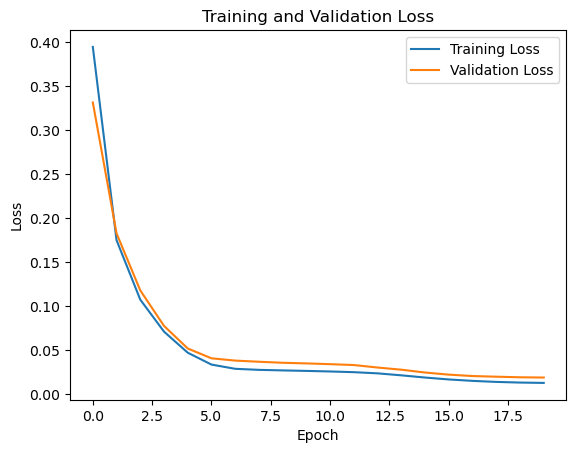

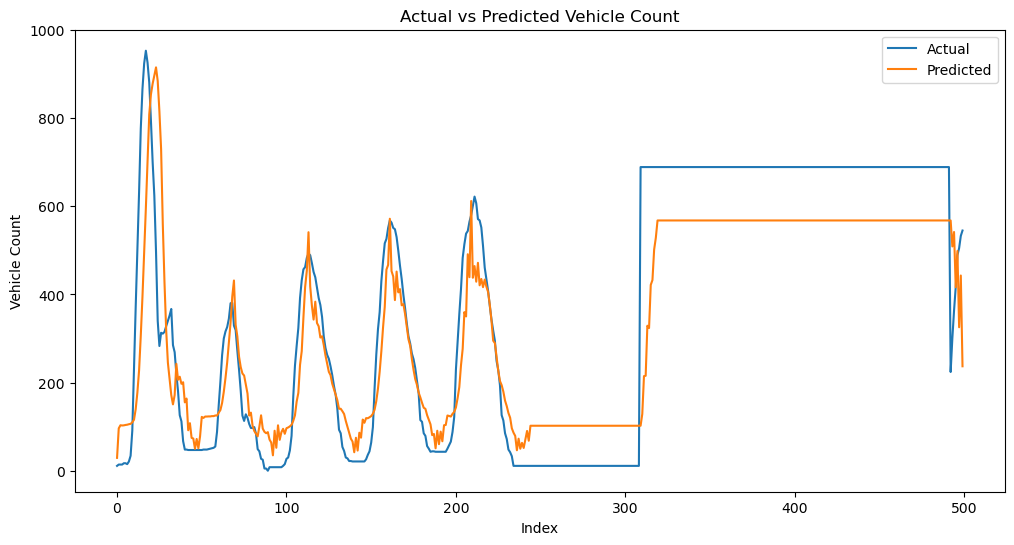

Parking Area: BUSGADEHUSET
Train Loss: 0.0022882225457578897
Test Loss: 0.001360987196676433
MAE: 18.949664256883704



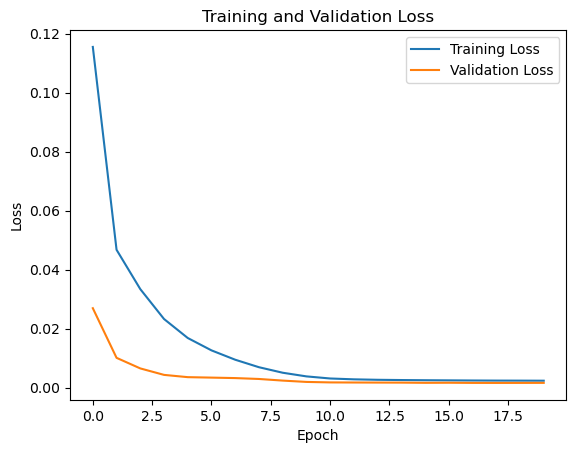

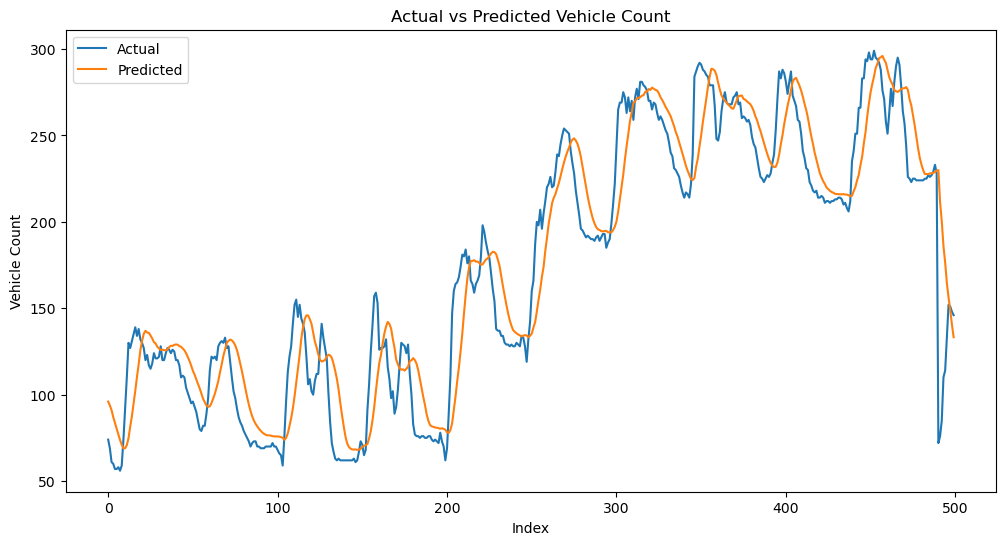

Parking Area: KALKVAERKSVEJ
Train Loss: 0.005770742893218994
Test Loss: 0.008282957598567009
MAE: 10.47484705430874



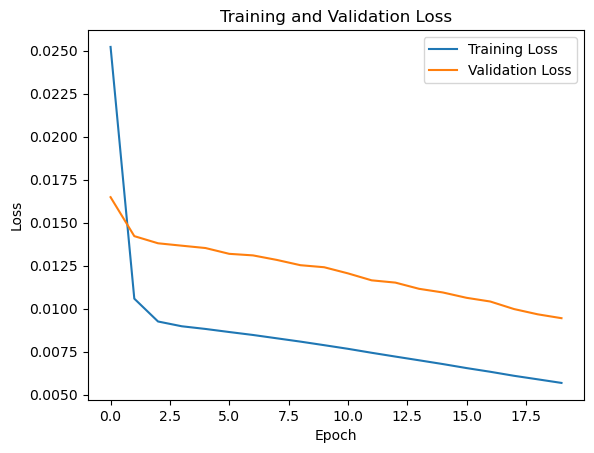

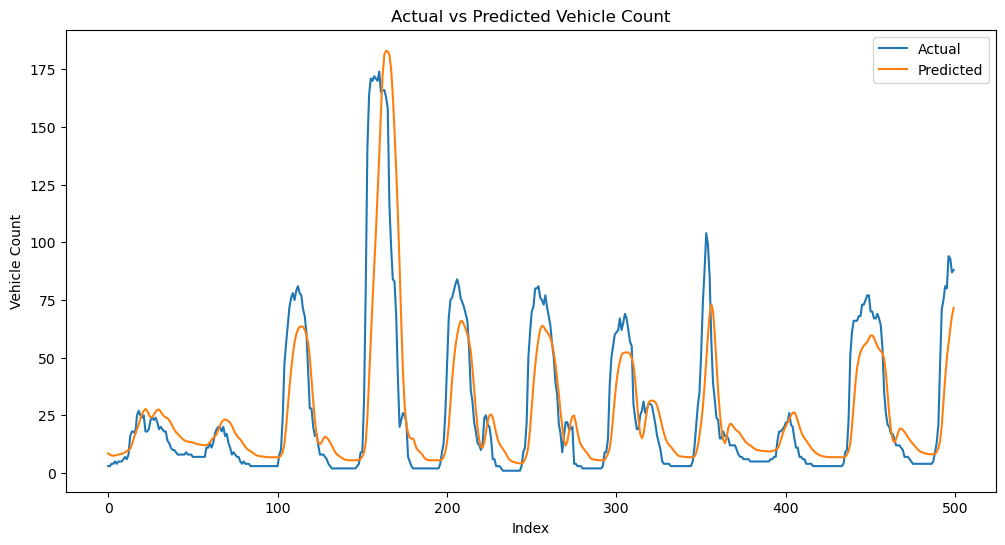

Parking Area: MAGASIN
Train Loss: 0.02296583727002144
Test Loss: 0.025660675019025803
MAE: 44.21515581711479



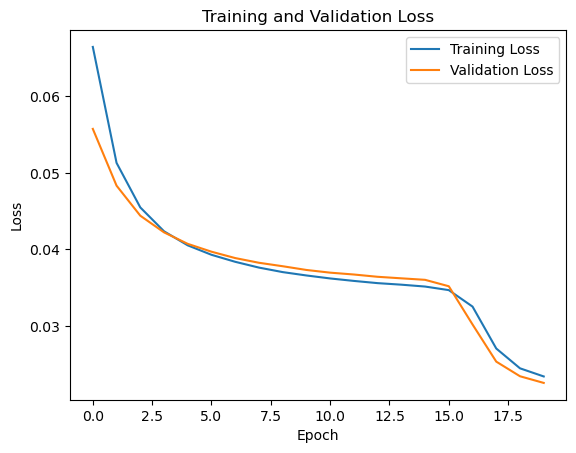

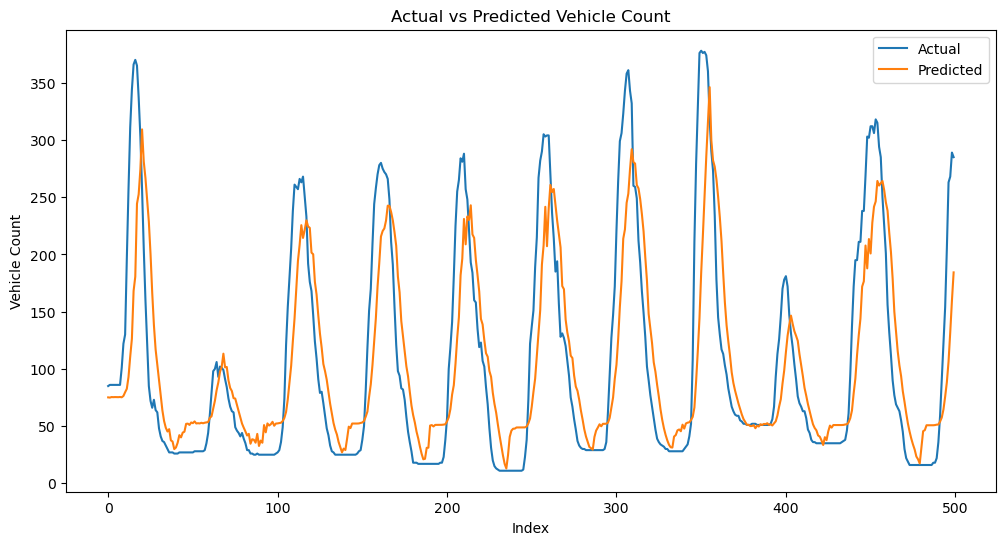

Parking Area: NORREPORT
Train Loss: 0.00020719203166663647
Test Loss: 3.259140066802502e-05
MAE: 6.345366072654724



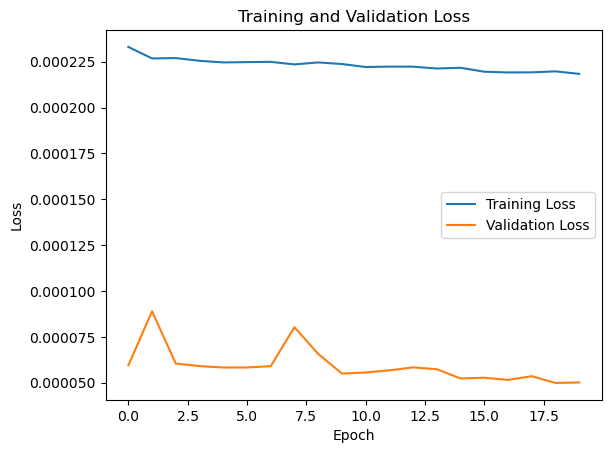

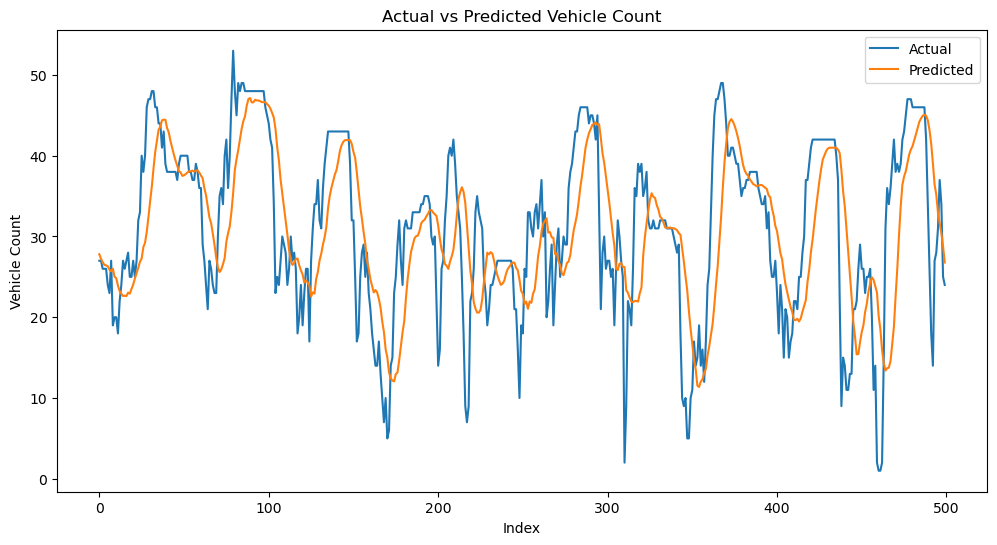

Parking Area: SALLING
Train Loss: 0.02472447231411934
Test Loss: 0.032257311046123505
MAE: 99.33057679438936



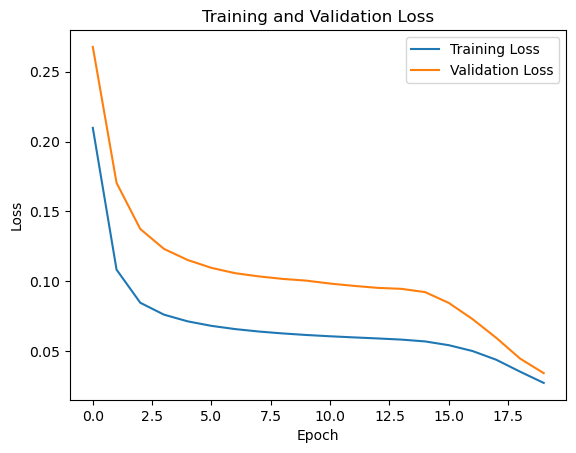

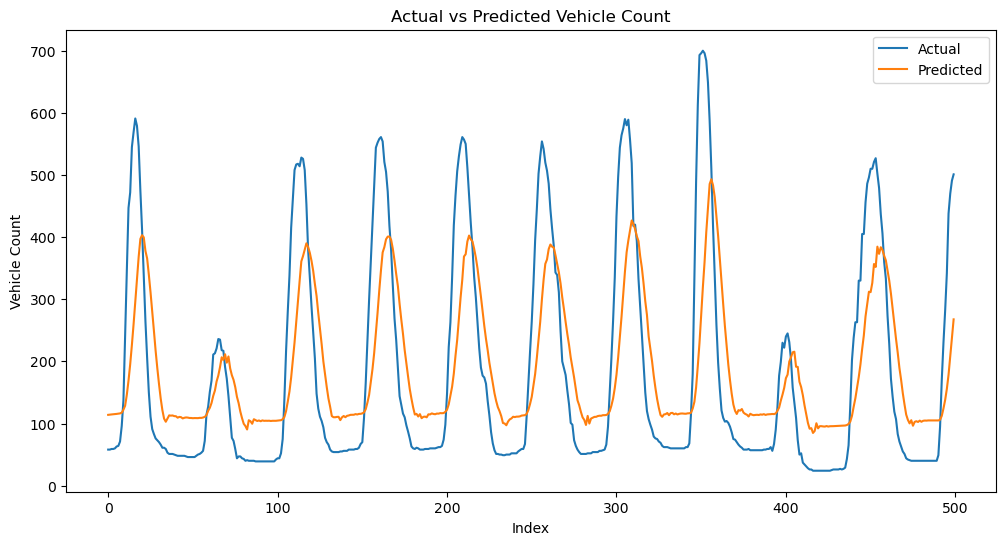

Parking Area: SCANDCENTER
Train Loss: 0.010432455688714981
Test Loss: 0.01267289835959673
MAE: 95.40104024444801



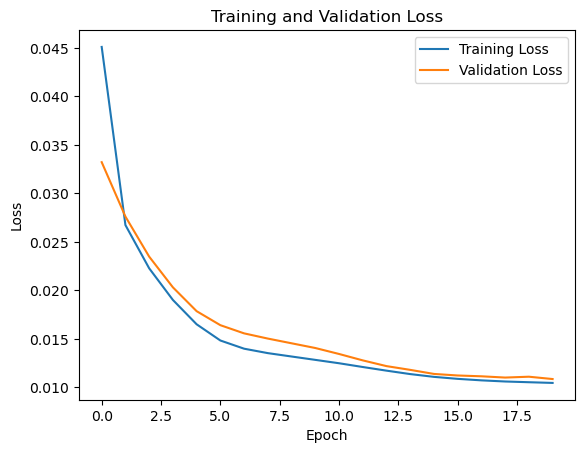

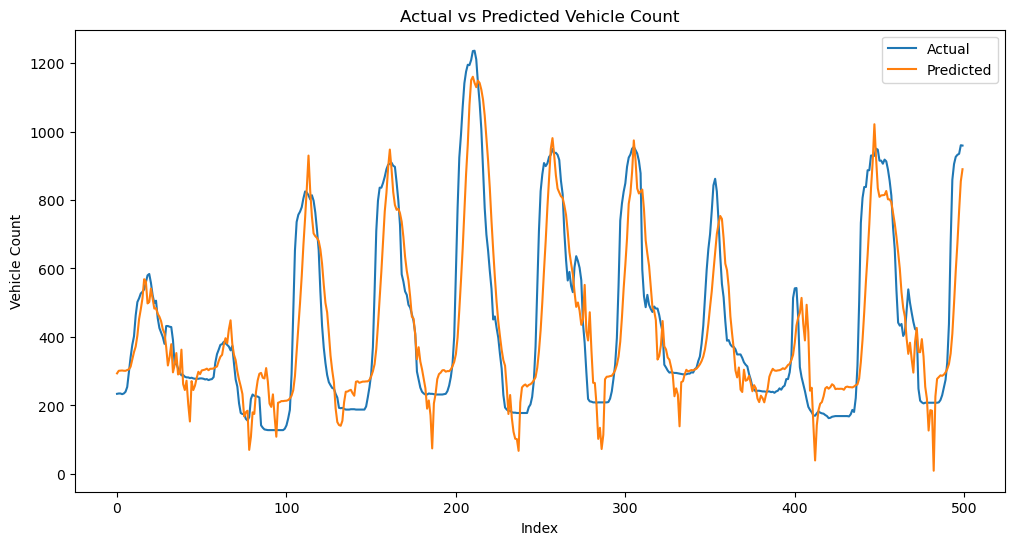

Parking Area: SKOLEBAKKEN
Train Loss: 0.0012448214692994952
Test Loss: 2.0988784399378346e-06
MAE: 0.74322509765625



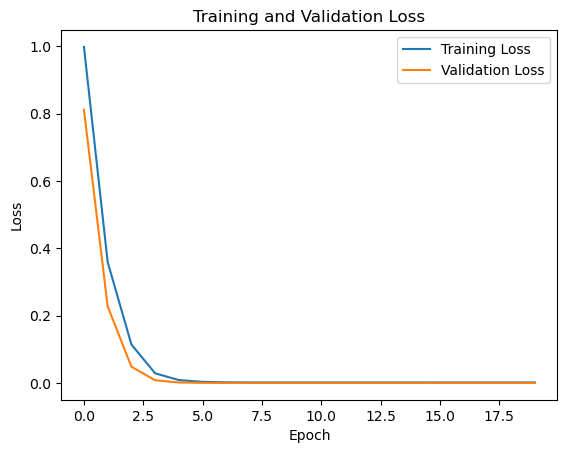

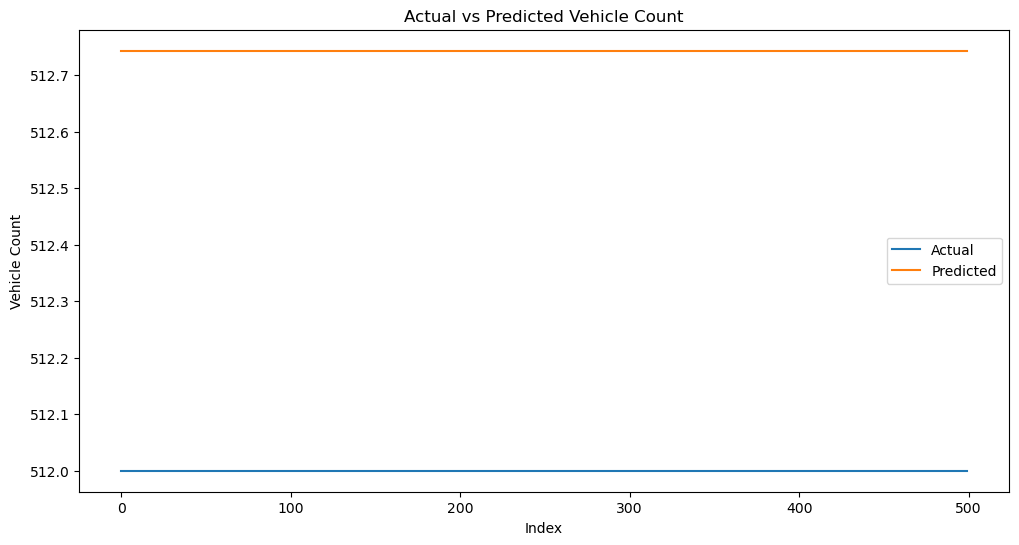

In [95]:
# Print results
for area_id, rnn_result in rnn_results.items():
    print(f"Parking Area: {area_id}")
    print(f"Train Loss: {rnn_result['train_loss']}")
    print(f"Test Loss: {rnn_result['test_loss']}")
    print(f"MAE: {rnn_result['mae']}")
    print()
    # Plot training and validation loss
    visualize_loss(rnn_result['loss'], rnn_result['val_loss'])

    # Plot actual vs predicted vehicle count
    visualize_model(rnn_result['y_test'], rnn_result['y_test_pred'])

In [59]:
# Take results and results_rnn that are both indexed by area_id and display a table of the results, pick only mse and mae columns
results_df = pd.DataFrame(results).T[['mse', 'mae']]
results_rnn_df = pd.DataFrame(rnn_results).T[['mse', 'mae']]
results_df.columns = ['LSTM MSE', 'LSTM MAE']
results_rnn_df.columns = ['RNN MSE', 'RNN MAE']
results_df = pd.concat([results_df, results_rnn_df], axis=1)
results_df

LSTM MSE    LSTM MAE       RNN MSE    RNN MAE
BRUUNS          4163.379506   49.000777  18487.096737  98.515825
BUSGADEHUSET    1093.265994   30.445057    475.075845  15.491132
KALKVAERKSVEJ    168.459997   12.180238    297.375963  12.633385
MAGASIN         4524.225277   63.352973   1143.829339  25.320713
NORREPORT        288.869504   13.404891    173.044308  10.979335
SALLING        25933.679012  157.052451   7687.471707  66.183211
SCANDCENTER    11038.872104   74.655893  19092.977164   96.24484
SKOLEBAKKEN       67.444556    8.212463       0.12493   0.353455